# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

#%matplotlib inline
#tf.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [6]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [8]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [9]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [10]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [11]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [12]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [13]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [15]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.2878 - val_loss: 1.0519
Epoch 2/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2854 - val_loss: 1.0502
Epoch 3/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2830 - val_loss: 1.0486
Epoch 4/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2807 - val_loss: 1.0469
Epoch 5/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2784 - val_loss: 1.0453
Epoch 6/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2761 - val_loss: 1.0437
Epoch 7/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2738 - val_loss: 1.0420
Epoch 8/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2714 - val_loss: 1.0404
Epoch 9/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2691 - val_loss: 1.0387
Epoch 10/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.266

149/149 [==============================] - 0s 2ms/step - loss: 1.1445 - val_loss: 0.9514
Epoch 81/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.1431 - val_loss: 0.9505
Epoch 82/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.1418 - val_loss: 0.9496
Epoch 83/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.1405 - val_loss: 0.9487
Epoch 84/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.1392 - val_loss: 0.9478
Epoch 85/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.1379 - val_loss: 0.9469
Epoch 86/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.1366 - val_loss: 0.9460
Epoch 87/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.1353 - val_loss: 0.9450
Epoch 88/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.1341 - val_loss: 0.9441
Epoch 89/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.1328 - v

149/149 [==============================] - 0s 2ms/step - loss: 1.0624 - val_loss: 0.8931
Epoch 160/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0616 - val_loss: 0.8925
Epoch 161/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0609 - val_loss: 0.8920
Epoch 162/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0601 - val_loss: 0.8914
Epoch 163/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0593 - val_loss: 0.8909
Epoch 164/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0585 - val_loss: 0.8903
Epoch 165/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0578 - val_loss: 0.8898
Epoch 166/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0570 - val_loss: 0.8892
Epoch 167/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0563 - val_loss: 0.8887
Epoch 168/1000
149/149 [==============================] - 0s 1ms/step - loss: 1

Epoch 238/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0113 - val_loss: 0.8567
Epoch 239/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0108 - val_loss: 0.8563
Epoch 240/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0103 - val_loss: 0.8560
Epoch 241/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0097 - val_loss: 0.8556
Epoch 242/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0092 - val_loss: 0.8552
Epoch 243/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0087 - val_loss: 0.8548
Epoch 244/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0081 - val_loss: 0.8544
Epoch 245/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0076 - val_loss: 0.8540
Epoch 246/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0071 - val_loss: 0.8536
Epoch 247/1000
149/149 [==============================] - 0s 2ms

Epoch 317/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9723 - val_loss: 0.8252
Epoch 318/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9719 - val_loss: 0.8248
Epoch 319/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9714 - val_loss: 0.8244
Epoch 320/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9709 - val_loss: 0.8239
Epoch 321/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9704 - val_loss: 0.8235
Epoch 322/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9700 - val_loss: 0.8231
Epoch 323/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9695 - val_loss: 0.8227
Epoch 324/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9690 - val_loss: 0.8223
Epoch 325/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9685 - val_loss: 0.8218
Epoch 326/1000
149/149 [==============================] - 0s 1ms

Epoch 396/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9336 - val_loss: 0.7900
Epoch 397/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9331 - val_loss: 0.7896
Epoch 398/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9326 - val_loss: 0.7891
Epoch 399/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9321 - val_loss: 0.7886
Epoch 400/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9315 - val_loss: 0.7881
Epoch 401/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9310 - val_loss: 0.7877
Epoch 402/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9305 - val_loss: 0.7872
Epoch 403/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9300 - val_loss: 0.7867
Epoch 404/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9295 - val_loss: 0.7862
Epoch 405/1000
149/149 [==============================] - 0s 2ms

149/149 [==============================] - 0s 2ms/step - loss: 0.8916 - val_loss: 0.7502
Epoch 475/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8911 - val_loss: 0.7496
Epoch 476/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8905 - val_loss: 0.7491
Epoch 477/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8899 - val_loss: 0.7485
Epoch 478/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8893 - val_loss: 0.7480
Epoch 479/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8888 - val_loss: 0.7474
Epoch 480/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8882 - val_loss: 0.7468
Epoch 481/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8876 - val_loss: 0.7463
Epoch 482/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8870 - val_loss: 0.7457
Epoch 483/1000
149/149 [==============================] - 0s 1ms/step - loss: 0

149/149 [==============================] - 0s 2ms/step - loss: 0.8454 - val_loss: 0.7049
Epoch 553/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8448 - val_loss: 0.7043
Epoch 554/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8442 - val_loss: 0.7037
Epoch 555/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8436 - val_loss: 0.7031
Epoch 556/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8430 - val_loss: 0.7025
Epoch 557/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8423 - val_loss: 0.7018
Epoch 558/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8417 - val_loss: 0.7012
Epoch 559/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8411 - val_loss: 0.7006
Epoch 560/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8405 - val_loss: 0.7000
Epoch 561/1000
149/149 [==============================] - 0s 2ms/step - loss: 0

Epoch 631/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7951 - val_loss: 0.6553
Epoch 632/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7944 - val_loss: 0.6547
Epoch 633/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7938 - val_loss: 0.6541
Epoch 634/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7931 - val_loss: 0.6534
Epoch 635/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7924 - val_loss: 0.6528
Epoch 636/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7918 - val_loss: 0.6521
Epoch 637/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7911 - val_loss: 0.6515
Epoch 638/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7905 - val_loss: 0.6508
Epoch 639/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.7898 - val_loss: 0.6502
Epoch 640/1000
149/149 [==============================] - 1s 4ms

Epoch 710/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7423 - val_loss: 0.6043
Epoch 711/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7416 - val_loss: 0.6037
Epoch 712/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7410 - val_loss: 0.6030
Epoch 713/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7403 - val_loss: 0.6024
Epoch 714/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7397 - val_loss: 0.6018
Epoch 715/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7390 - val_loss: 0.6011
Epoch 716/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7383 - val_loss: 0.6004
Epoch 717/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7376 - val_loss: 0.5998
Epoch 718/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7370 - val_loss: 0.5991
Epoch 719/1000
149/149 [==============================] - 0s 1ms

Epoch 789/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6897 - val_loss: 0.5536
Epoch 790/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6891 - val_loss: 0.5530
Epoch 791/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6884 - val_loss: 0.5524
Epoch 792/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6878 - val_loss: 0.5518
Epoch 793/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6872 - val_loss: 0.5512
Epoch 794/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6865 - val_loss: 0.5506
Epoch 795/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6859 - val_loss: 0.5500
Epoch 796/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6852 - val_loss: 0.5494
Epoch 797/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6846 - val_loss: 0.5488
Epoch 798/1000
149/149 [==============================] - 0s 1ms

Epoch 868/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6404 - val_loss: 0.5074
Epoch 869/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6398 - val_loss: 0.5068
Epoch 870/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6392 - val_loss: 0.5063
Epoch 871/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6386 - val_loss: 0.5057
Epoch 872/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6380 - val_loss: 0.5052
Epoch 873/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6374 - val_loss: 0.5046
Epoch 874/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6368 - val_loss: 0.5041
Epoch 875/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6362 - val_loss: 0.5035
Epoch 876/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6357 - val_loss: 0.5030
Epoch 877/1000
149/149 [==============================] - 0s 2ms

Epoch 947/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5960 - val_loss: 0.4662
Epoch 948/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5955 - val_loss: 0.4658
Epoch 949/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5949 - val_loss: 0.4653
Epoch 950/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5944 - val_loss: 0.4648
Epoch 951/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5939 - val_loss: 0.4643
Epoch 952/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.4639
Epoch 953/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5929 - val_loss: 0.4634
Epoch 954/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5923 - val_loss: 0.4630
Epoch 955/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5918 - val_loss: 0.4625
Epoch 956/1000
149/149 [==============================] - 0s 1ms

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

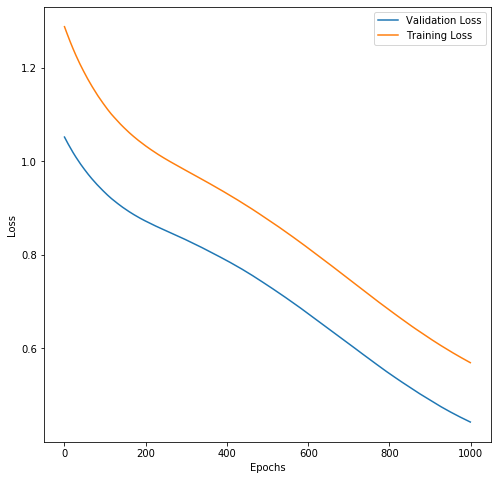

In [18]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

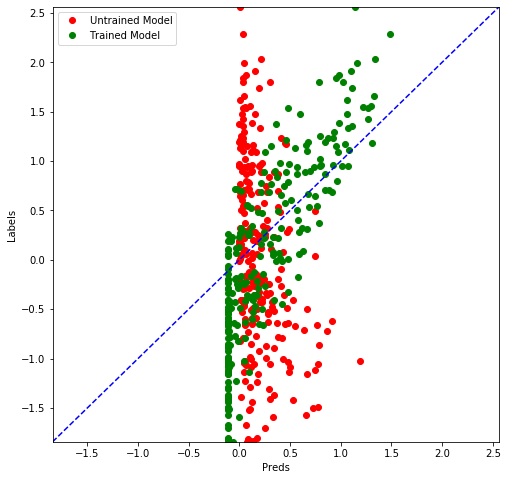

In [19]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

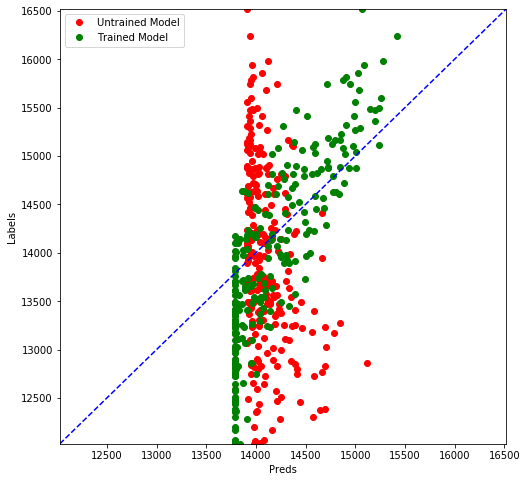

In [20]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)